In [1]:
import os
import pandas as pd
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

## Homework

The goal of this homework is to get familiar with MLflow, the tool for experiment tracking and 
model management.


## Q1. Install MLflow

To get started with MLflow you'll need to install the MLflow Python package.

For this we recommend creating a separate Python environment, for example, you can use [conda environments](https://docs.conda.io/projects/conda/en/latest/user-guide/getting-started.html#managing-envs), and then install the package there with `pip` or `conda`.

Once you installed the package, run the command `mlflow --version` and check the output.

What's the version that you have?


In [2]:
!mlflow --version

mlflow, version 2.21.3


## Q2. Download and preprocess the data

We'll use the Green Taxi Trip Records dataset to predict the duration of each trip. 

Download the data for January, February and March 2023 in parquet format from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).


In [3]:
TAXI_DATA_FOLDER = "./data"
OUTPUT_FOLDER = "./output"
DATA_URL = 'https://d37ci6vzurychx.cloudfront.net/trip-data'

In [4]:
if not os.path.isdir(TAXI_DATA_FOLDER): 
    
    # if the directory is  
    # not present then create it. 
    os.makedirs(TAXI_DATA_FOLDER)
    print(f"The {TAXI_DATA_FOLDER} directory is created")

In [5]:
# Donwloading datasets
#downloading_file = [TRAIN_FILE, VAL_FILE, TEST_FILE]
for month in range(1, 4):
    fdata = f'green_tripdata_2023-{month:02d}.parquet'
    data_path = os.path.join(TAXI_DATA_FOLDER, fdata)
    if os.path.isfile(data_path):
        print(f"The {fdata} file exists")
        continue
    print(f"Downloading file {fdata} from {DATA_URL}/{fdata}")
    !curl -o {data_path} {DATA_URL}/{fdata}
    print(f"The {fdata} file is downloaded")

The green_tripdata_2023-01.parquet file exists
The green_tripdata_2023-02.parquet file exists
The green_tripdata_2023-03.parquet file exists


In [6]:
!ls -l {TAXI_DATA_FOLDER}

total 4588
-rw-rw-rw- 1 codespace codespace 1427002 May 25 18:45 green_tripdata_2023-01.parquet
-rw-rw-rw- 1 codespace codespace 1533740 May 25 18:45 green_tripdata_2023-02.parquet
-rw-rw-rw- 1 codespace codespace 1730999 May 25 18:45 green_tripdata_2023-03.parquet


Use the script `preprocess_data.py` located in the folder [`homework`](homework) to preprocess the data.

The script will:

* load the data from the folder `<TAXI_DATA_FOLDER>` (the folder where you have downloaded the data),
* fit a `DictVectorizer` on the training set (January 2023 data),
* save the preprocessed datasets and the `DictVectorizer` to disk.

Your task is to download the datasets and then execute this command:

```
python preprocess_data.py --raw_data_path <TAXI_DATA_FOLDER> --dest_path ./output
```

Tip: go to `02-experiment-tracking/homework/` folder before executing the command and change the value of `<TAXI_DATA_FOLDER>` to the location where you saved the data.



In [7]:
!python preprocess_data.py --raw_data_path {TAXI_DATA_FOLDER} --dest_path {OUTPUT_FOLDER}

In [8]:
!ls -lh {OUTPUT_FOLDER}

total 6.9M
-rw-rw-rw- 1 codespace codespace 128K May 25 23:56 dv.pkl
-rw-rw-rw- 1 codespace codespace 2.4M May 25 23:56 test.pkl
-rw-rw-rw- 1 codespace codespace 2.3M May 25 23:56 train.pkl
-rw-rw-rw- 1 codespace codespace 2.2M May 25 23:56 val.pkl


There are 4 files: **dv.pkl**, **test.pkl**, **train.pkl** and **val.pkl**

How many files were saved to `OUTPUT_FOLDER`?

* 1
* 3
* **4** <span style="font-size: 1.2em;">⬅️</span>
* 7

## Q3. Train a model with autolog

We will train a `RandomForestRegressor` (from Scikit-Learn) on the taxi dataset.

We have prepared the training script `train.py` for this exercise, which can be also found in the folder [`homework`](homework). 

The script will:

* load the datasets produced by the previous step,
* train the model on the training set,
* calculate the RMSE score on the validation set.

Your task is to modify the script to enable **autologging** with MLflow, execute the script and then launch the MLflow UI to check that the experiment run was properly tracked. 

Tip 1: don't forget to wrap the training code with a `with mlflow.start_run():` statement as we showed in the videos.

Tip 2: don't modify the hyperparameters of the model to make sure that the training will finish quickly.



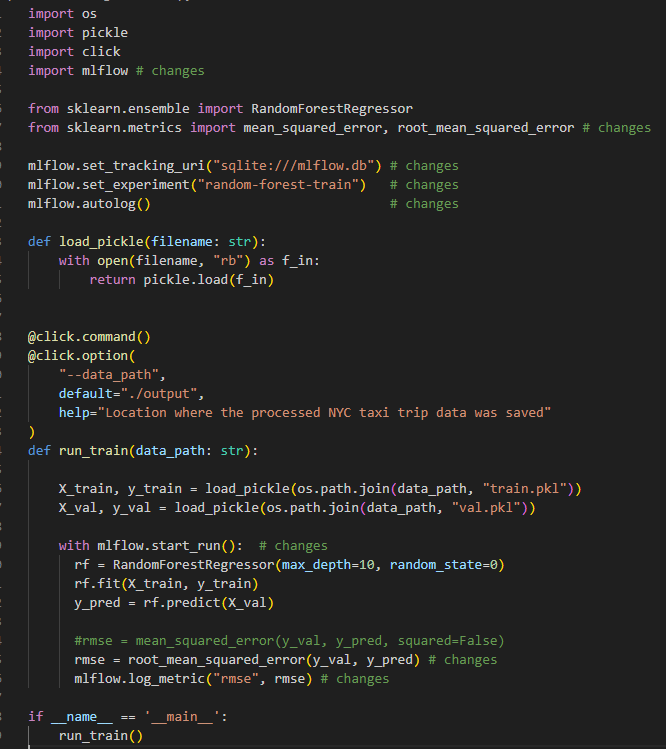

In [9]:
!python train.py

2025/05/25 23:56:58 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-train' does not exist. Creating a new experiment.
2025/05/25 23:56:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


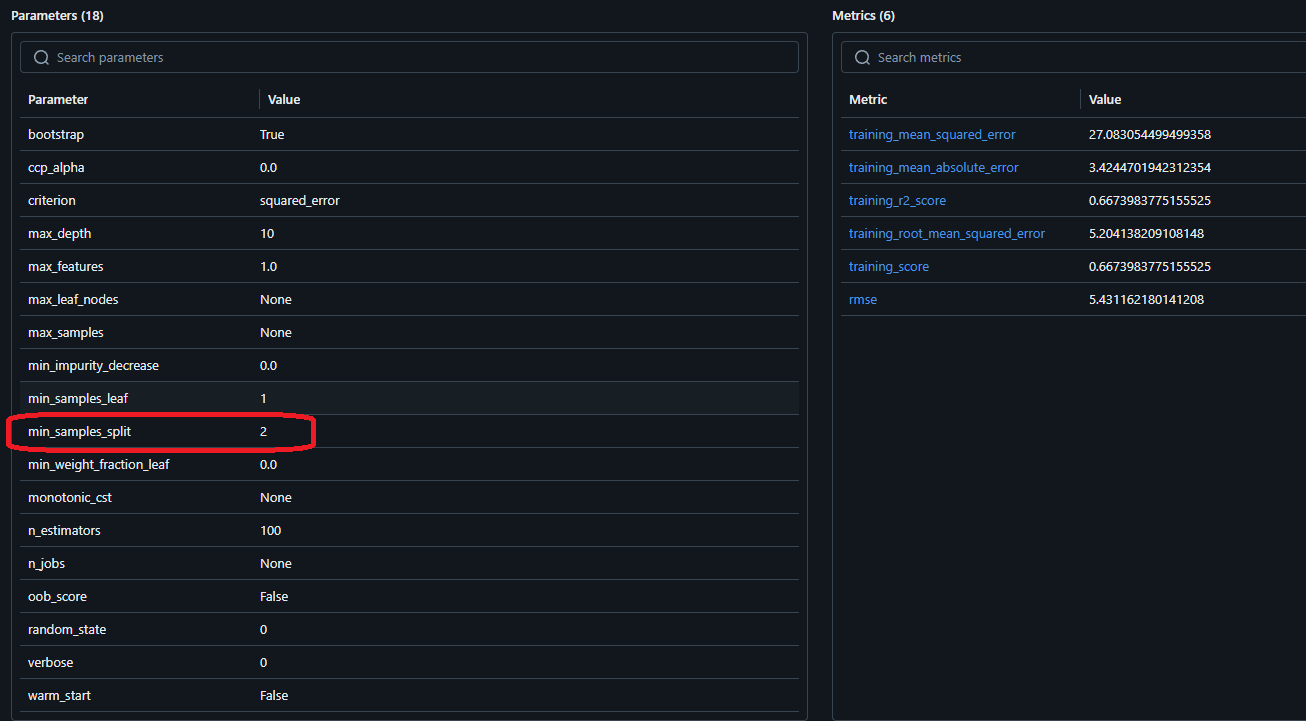

In [10]:
#mlflow ui --backend-store-uri sqlite:///mlflow.db

In [11]:
mlflow.set_tracking_uri("http://localhost:5000")

In [12]:
# Connect al cliente de MLflow
client = MlflowClient()

In [14]:
experiments = mlflow.search_experiments()
for exp in experiments:
    print(f"Experiment ID: {exp.experiment_id}, Name: {exp.name}")

Experiment ID: 1, Name: random-forest-train
Experiment ID: 0, Name: Default


In [15]:
# Get experiment ID by name
TRAIN_EXPERIMENT_NAME = "random-forest-train"
def print_exp_info(exp_name: str, metric_name: str, max_results = 5):
    experiment = client.get_experiment_by_name(exp_name)
    best_run = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=max_results,
        order_by=[f'metrics.{metric_name} ASC']
    )[0]
    metric_value = best_run.data.metrics.get(metric_name)
    print("="*50)
    print(f"Run ID: {best_run.info.run_id}")
    print(f"{metric_name}: {metric_value}") 
    print(f"Params: {best_run.data.params}")
    print("="*50)
    
print_exp_info(TRAIN_EXPERIMENT_NAME, "rmse")

Run ID: 848d276dd1fd45f590d56b23fdb7747b
rmse: 5.431162180141208
Params: {'bootstrap': 'True', 'ccp_alpha': '0.0', 'criterion': 'squared_error', 'max_depth': '10', 'max_features': '1.0', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'monotonic_cst': 'None', 'n_estimators': '100', 'n_jobs': 'None', 'oob_score': 'False', 'random_state': '0', 'verbose': '0', 'warm_start': 'False'}


What is the value of the `min_samples_split` parameter:

* **2** <span style="font-size: 1.2em;">⬅️</span>
* 4
* 8
* 10


## Q4. Launch the tracking server locally

Now we want to manage the entire lifecycle of our ML model. In this step, you'll need to launch a tracking server. This way we will also have access to the model registry. 

Your task is to:

* launch the tracking server on your local machine,
* select a SQLite db for the backend store and a folder called `artifacts` for the artifacts store.

You should keep the tracking server running to work on the next two exercises that use the server.

In [16]:
#mlflow ui --backend-store-uri sqlite:///mlflow.db --default-artifact-root artifacts

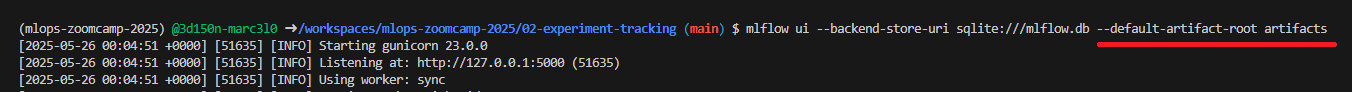

In addition to `backend-store-uri`, what else do you need to pass to properly configure the server?

* **`default-artifact-root`** <span style="font-size: 1.2em;">⬅️</span>
* `serve-artifacts`
* `artifacts-only`
* `artifacts-destination`

## Q5. Tune model hyperparameters

Now let's try to reduce the validation error by tuning the hyperparameters of the `RandomForestRegressor` using `hyperopt`. 
We have prepared the script `hpo.py` for this exercise. 

Your task is to modify the script `hpo.py` and make sure that the validation RMSE is logged to the tracking server for each run of the hyperparameter optimization (you will need to add a few lines of code to the `objective` function) and run the script without passing any parameters.

After that, open UI and explore the runs from the experiment called `random-forest-hyperopt` to answer the question below.

Note: Don't use autologging for this exercise.

The idea is to just log the information that you need to answer the question below, including:

* the list of hyperparameters that are passed to the `objective` function during the optimization,
* the RMSE obtained on the validation set (February 2023 data).



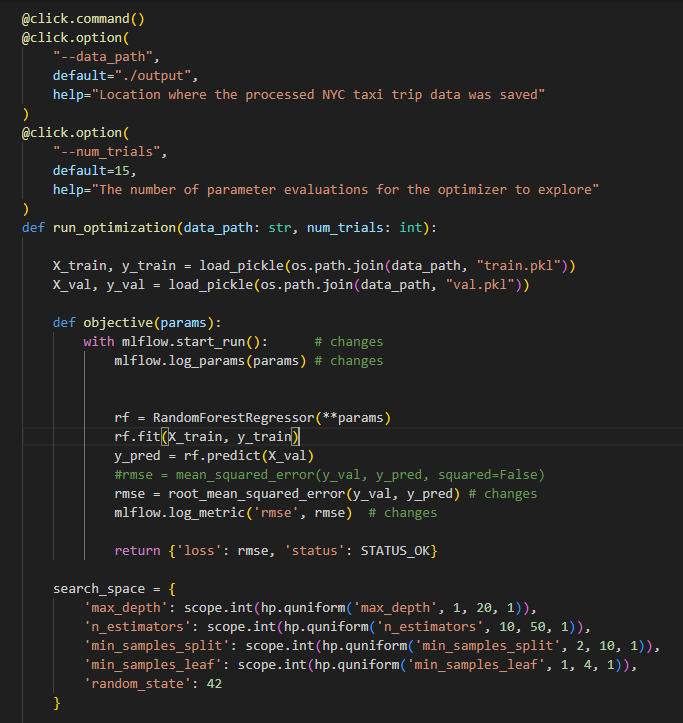

In [19]:
# Run HPO
!python hpo.py

🏃 View run gifted-fox-418 at: http://127.0.0.1:5000/#/experiments/2/runs/3207dc4c585148b3bb0d3f68a195fa7b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2                    

🏃 View run marvelous-stork-54 at: http://127.0.0.1:5000/#/experiments/2/runs/47ed2601bcdf4d6195c11615517b0f24

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2                    

🏃 View run legendary-yak-953 at: http://127.0.0.1:5000/#/experiments/2/runs/7c39bccef37e4a2b941ae1b5713e2067

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2                    

🏃 View run auspicious-ray-403 at: http://127.0.0.1:5000/#/experiments/2/runs/b9c8cffffdcd44c4a834366b20769eec

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2                    

🏃 View run kindly-snail-492 at: http://127.0.0.1:5000/#/experiments/2/runs/fd80cae9a9fa43ffb122967f18398637

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2                    

🏃 View run upset-gull-201 at: http://127.0.0.1:

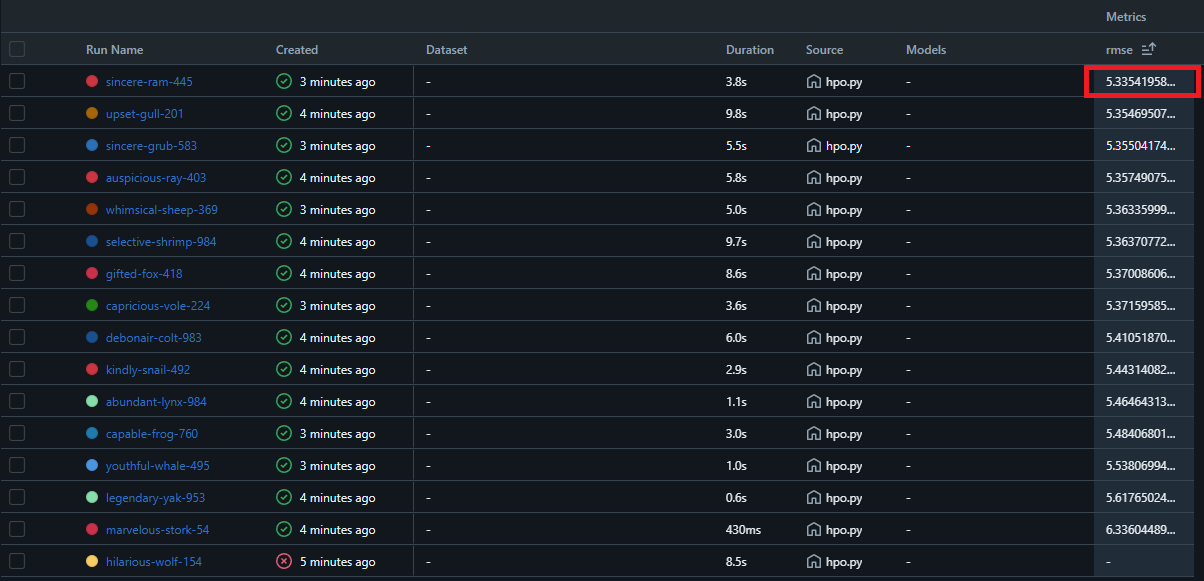

In [20]:
# Search best results
HPO_EXPERIMENT_NAME = "random-forest-hyperopt"

In [21]:
print_exp_info(HPO_EXPERIMENT_NAME, "rmse")

Run ID: 695b84dc66bb49c9bcaeea64a024a7d1
rmse: 5.335419588556921
Params: {'max_depth': '19', 'min_samples_leaf': '2', 'min_samples_split': '2', 'n_estimators': '11', 'random_state': '42'}


What's the best validation RMSE that you got?

* 4.817
* **5.335** <span style="font-size: 1.2em;">⬅️</span>
* 5.818
* 6.336


## Q6. Promote the best model to the model registry

The results from the hyperparameter optimization are quite good. So, we can assume that we are ready to test some of these models in production. 
In this exercise, you'll promote the best model to the model registry. We have prepared a script called `register_model.py`, which will check the results from the previous step and select the top 5 runs. 
After that, it will calculate the RMSE of those models on the test set (March 2023 data) and save the results to a new experiment called `random-forest-best-models`.

Your task is to update the script `register_model.py` so that it selects the model with the lowest RMSE on the test set and registers it to the model registry.

Tip 1: you can use the method `search_runs` from the `MlflowClient` to get the model with the lowest RMSE,

Tip 2: to register the model you can use the method `mlflow.register_model` and you will need to pass the right `model_uri` in the form of a string that looks like this: `"runs:/<RUN_ID>/model"`, and the name of the model (make sure to choose a good one!).




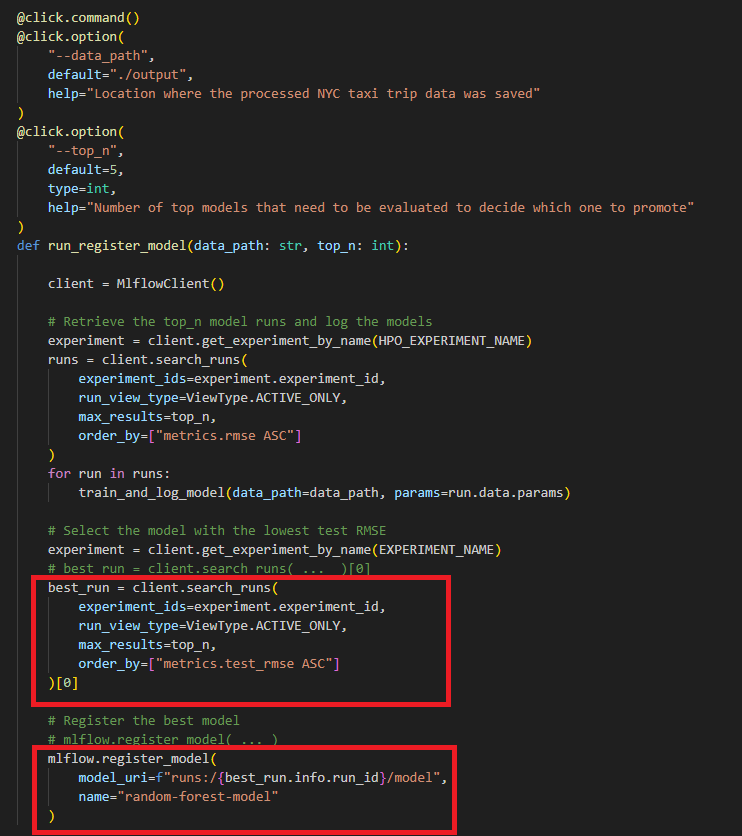

In [23]:
!python register_model.py

🏃 View run redolent-toad-712 at: http://127.0.0.1:5000/#/experiments/3/runs/a6a002af85614bdbb5850698a523124c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
🏃 View run stylish-ant-67 at: http://127.0.0.1:5000/#/experiments/3/runs/fcca8fa694a54be2820b4d135e15cbf7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
🏃 View run kindly-vole-524 at: http://127.0.0.1:5000/#/experiments/3/runs/3b2b6c137d54457699f8b2b57133917f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
🏃 View run painted-bass-821 at: http://127.0.0.1:5000/#/experiments/3/runs/7fa3b643082742cf9cc5fed51e887067
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
🏃 View run adaptable-fly-160 at: http://127.0.0.1:5000/#/experiments/3/runs/a09324674f074b73831311f5bcccf843
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
Successfully registered model 'random-forest-model'.
2025/05/26 00:28:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model ver

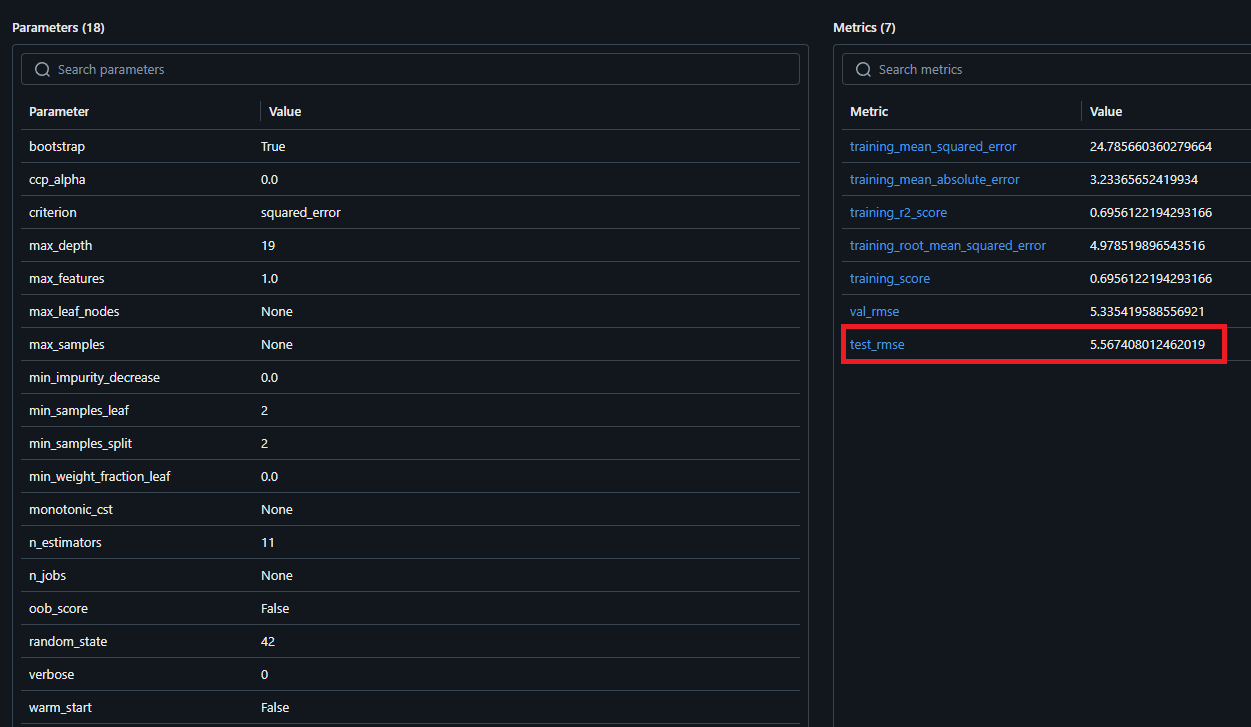

In [24]:
# Search best experiment
BEST_EXPERIMENT_NAME = "random-forest-best-models"

In [25]:
# Search best experiment
print_exp_info(BEST_EXPERIMENT_NAME, "test_rmse")

Run ID: a6a002af85614bdbb5850698a523124c
test_rmse: 5.567408012462019
Params: {'bootstrap': 'True', 'ccp_alpha': '0.0', 'criterion': 'squared_error', 'max_depth': '19', 'max_features': '1.0', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '2', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'monotonic_cst': 'None', 'n_estimators': '11', 'n_jobs': 'None', 'oob_score': 'False', 'random_state': '42', 'verbose': '0', 'warm_start': 'False'}


What is the test RMSE of the best model?

* 5.060
* **5.567** <span style="font-size: 1.2em;">⬅️</span>
* 6.061
* 6.568


## Submit the results

* Submit your results here: https://courses.datatalks.club/mlops-zoomcamp-2025/homework/hw2
* If your answer doesn't match options exactly, select the closest one
